# Method 1: Using Pystan

I'll do this for a single n, and treat the mode locations as fixed for now.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from astropy.units import cds
from astropy import units as u
import corner
import matplotlib
import pystan
import pickle
import os
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('axes',labelsize=20)
matplotlib.rcParams['text.usetex'] = False

#The stellar parameters are for 16 Cyg A
nus = 0.411 #uHz
i = np.deg2rad(56.) #rad
d02 = 6.8 #uHz
dnu = 102. #uHz

In [2]:
locs = np.genfromtxt('locs.txt')
mid = int(np.floor(len(locs)/2))
l0 = locs[mid, 0]
l1 = locs[mid, 1]
l2 = locs[mid-1, 2]
l3 = locs[mid-1, 3]
ff = np.genfromtxt('freqs.txt')
pp = np.genfromtxt('model.txt')

In [3]:
sel = [(ff >= 2185) & (ff <= 2200)]
f = ff[tuple(sel)]
p = pp[tuple(sel)] 

In [4]:
# modelocs = np.concatenate((l0, l1, l2, l3))
modelocs = np.array([l2, l0])
# modeids = [0]*len(l0) + [1]*len(l1) + [2]*len(l2) + [3]*len(l3)
modeids = [2, 0]

/home/oliver/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


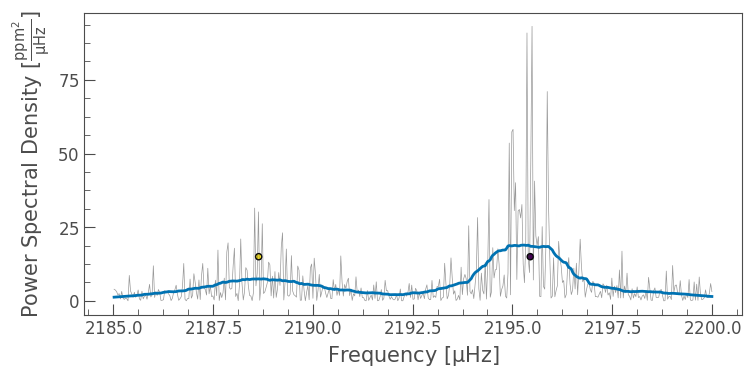

In [5]:
pg = lk.Periodogram(f*u.microhertz, p*(cds.ppm**2/u.microhertz))
ax = pg.plot(alpha=.5)
pg.smooth(filter_width=2.).plot(ax=ax, linewidth=2)
plt.scatter(modelocs, [15]*len(modelocs),c=modeids, s=20, edgecolor='k')
plt.show()

Lets fit a group of lorentzians to these data!

In [46]:
overwrite = True
pbjam = '''
functions{      
    vector lorentzian(real loc, int l, int m, vector f, real eps, real H, real w, real nus){
        return (eps * H) ./ (1 + (4/w^2) * square(f - loc + m*nus));
    }
}
data{
    int N;            // Number of data points
    int M;            // Number of modes
    vector[N] f;      // Frequency
    vector[N] p;      // Power
    real asy_locs[M]; // Mode locations (this will have to change for multiple n modes)
    int asy_ids[M];   // The ID's of the modes
}
parameters{
    real logAmp[M];         // Mode amplitude in log space
    real logGamma[M];       // Mode linewidth in log space
    real locs[M];  // True mode locations
    real vsini;    // Line of sight rotational frequency
    real<lower=0.> nus;      // Rotational frequency splitting
}
transformed parameters{
    real H[M];       // Mode height
    real w[M];       // Mode linewidth
    
    for (m in 1:M){
        w[m] = 10^logGamma[m];             // Transform mode linewidth from log space
        H[m] = 10^logAmp[m] / pi() / w[m]; // Transform mode amplitude to mode height
    }
}
model{
    vector<lower=1.>[N] modes; // Our Model
    real i;          // Angle of inclination (rad)
    matrix[4,4] eps; // Matrix of legendre polynomials
    int l;           // The radial degree
    
    // First we'll calculate all the legendre polynomials for this i
    i = asin(vsini / nus);
    eps = rep_matrix(1., 4, 4);
    eps[0+1,0+1] = 1.;
    eps[1+1,0+1] = cos(i)^2;
    eps[1+1,1+1] = 0.5 * sin(i)^2;
    eps[2+1,0+1] = 0.25 * (3. * cos(i)^2 - 1.)^2;
    eps[2+1,1+1] = (3./8.)*sin(2*i)^2;
    eps[2+1,2+1] = (3./8.) * sin(i)^4;
    eps[3+1,0+1] = (1./64.)*(5.*cos(3.*i) + 3.*cos(i))^2;
    eps[3+1,1+1] = (3./64.)*(5.*cos(2.*i) + 3.)^2 * sin(i)^2;
    eps[3+1,2+1] = (15./8.)*cos(i)^2 * sin(i)^4;
    eps[3+1,3+1] = (5./16.)*sin(i)^6;    

    modes = rep_vector(1., N);
    for (mode in 1:M){        // Iterate over all modes passed in
        l = asy_ids[mode];    // Identify the Mode ID
        for (m in -l:l){      // Iterate over all m in a given l
            modes += lorentzian(locs[mode], l, m, f, eps[l+1,abs(m)+1], H[mode], w[mode], nus);
        }
    }

    // Model drawn from a gamma distribution scaled to the model (Anderson+1990)
    p ~ gamma(1., 1../modes);
    
    //priors on the parameters
    logAmp ~ normal(1.5, 1);
    logGamma ~ normal(0, 0.01);
    locs ~ normal(asy_locs, 1);
    nus ~ normal(0.411, 0.1);
    vsini ~ uniform(0.,nus);
}
'''
model_path = 'pbjam.pkl'
if overwrite:
    print('Updating Stan model')
    sm = pystan.StanModel(model_code = pbjam, model_name='pbjam')
    pkl_file =  open(model_path, 'wb')
    pickle.dump(sm, pkl_file)
    pkl_file.close()
if os.path.isfile(model_path):
    print('Reading in Stan model')
    sm = pickle.load(open(model_path, 'rb'))
else:
    print('Saving Stan Model')
    sm = pystan.StanModel(model_code = pbjam, model_name='pbjam')
    pkl_file =  open(model_path, 'wb')
    pickle.dump(sm, pkl_file)
    pkl_file.close()

Updating Stan model


ValueError: Failed to parse Stan model 'pbjam_513d740fcd49da1cf98ba1155456b810'. Error message:
SYNTAX ERROR, MESSAGE(S) FROM PARSER:

require unconstrained. found range constraint.
  error in 'unknown file name' at line 32, column 30
  -------------------------------------------------
    30: }
    31: model{
    32:     vector<lower=1.>[N] modes; // Our Model
                                     ^
    33:     real i;          // Angle of inclination (rad)
  -------------------------------------------------



In [26]:
data = {'N':len(f),
        'M': len(modelocs),
        'f':f,
        'p':p,
        'asy_locs':modelocs,
        'asy_ids':modeids}

init = {'logAmp' :   np.ones(len(modelocs))*1.5,
        'logGamma' : np.zeros(len(modelocs)),
        'nus':nus,
        'locs' : modelocs}

In [27]:
nchains = 4
fit = sm.sampling(data=data, iter=50, chains=nchains, init = [init for n in range(nchains)])

In [28]:
print(fit)

Inference for Stan model: pbjam_02968e38a317ae352bebb66f7b6c8ebf.
4 chains, each with iter=50; warmup=25; thin=1; 
post-warmup draws per chain=25, total post-warmup draws=100.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
logAmp[1]     1.72  6.8e-3   0.04   1.62    1.7   1.72   1.75   1.81     43   1.08
logAmp[2]     2.14  5.9e-3   0.04   2.06   2.11   2.13   2.16   2.23     46   1.03
logGamma[1] 4.5e-3  7.0e-4 9.0e-3  -0.02-1.3e-3 4.2e-3   0.01   0.02    163   0.98
logGamma[2] 1.5e-3  1.0e-3   0.01  -0.02-6.5e-3 6.3e-4 9.5e-3   0.02    100    1.0
locs[1]     2188.6    0.03   0.09 2188.4 2188.6 2188.6 2188.7 2188.7     10   1.48
locs[2]     2195.3    0.02   0.07 2195.2 2195.3 2195.3 2195.4 2195.5     12   1.25
vsini          0.4    0.02   0.05   0.31   0.37   0.41   0.43   0.51      5    1.4
nus           0.46    0.04   0.06   0.35   0.42   0.45    0.5    0.6      3   2.85
H[1]         16.57    0.25   1.73  13.07  15.53  16.54  17.51  20.29     47 

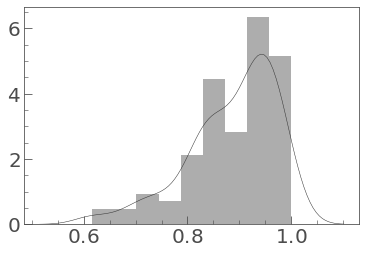

In [43]:
sini = fit['vsini']/fit['nus']
import seaborn as sns
sns.distplot(sini)

In [29]:
test = fit['test']
test.shape

(100, 4, 4)

In [40]:
e10 = test[:,1, 0]
e11 = test[:,1, 1]
e20 = test[:,2, 0]
e21 = test[:,2, 1]
e22 = test[:,2, 2]
e30 = test[:,3, 0]
e31 = test[:,3, 1]
e32 = test[:,3, 2]
e33 = test[:,3, 3]
labels = ['10','11','20','21','22','30','31','32','33']
chains = np.array([e10,e11,e20,e21,e22,e30,e31,e32,e33])

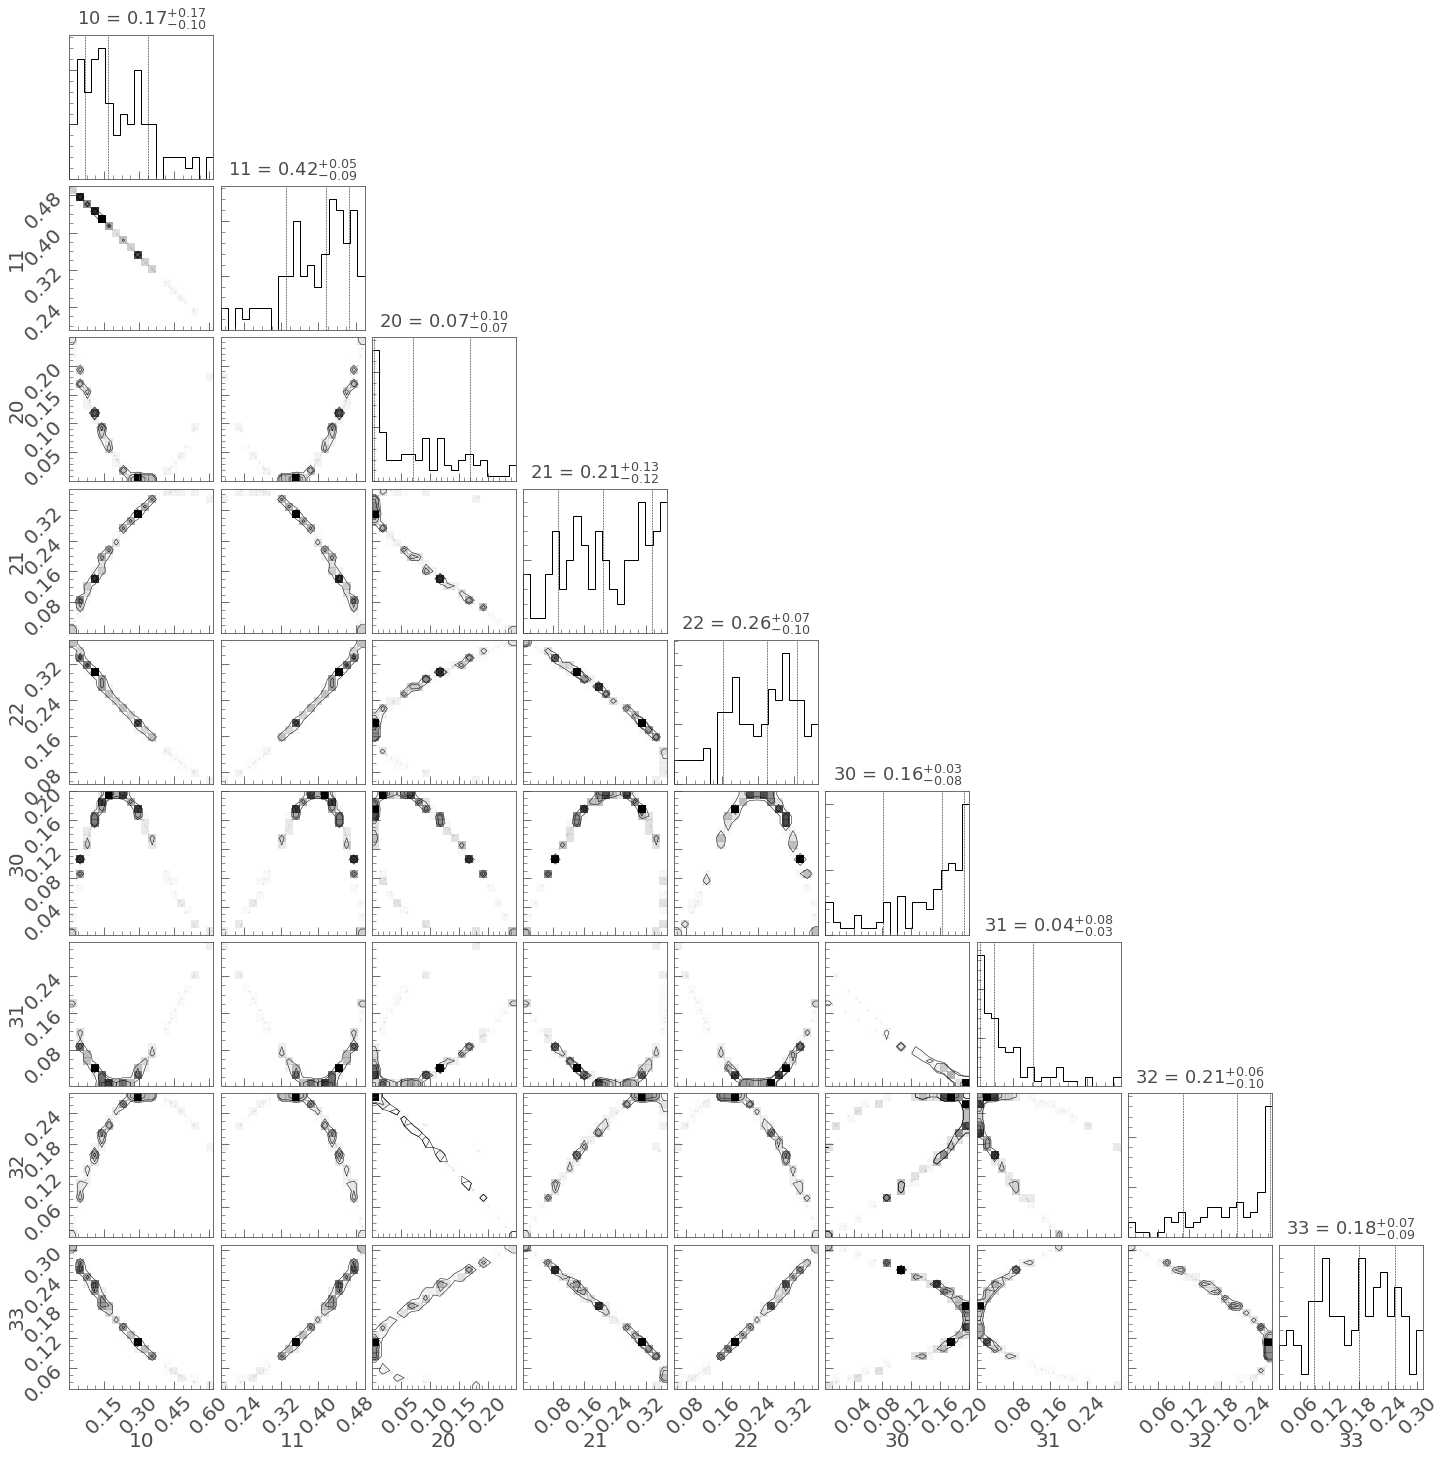

In [42]:
import corner
corner.corner(chains.T,labels=labels, quantiles=[0.16, 0.5, 0.84],show_titles=True)
plt.show()